In [316]:
# import pakages
from abcpy.continuousmodels import Uniform, Normal as Gaussian
from abcpy.statistics import Identity, LinearTransformation
import numpy as np
from abcpy.distances import Euclidean
from abcpy.backends import BackendDummy as Backend
from abcpy.inferences import RejectionABC
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

First we implement some useful distances.

In [368]:
# Implement various distances
def hell(y0, y1, step = 0.2):
    ''' Compute discrete hell distance for two data sets.
    :params y0, y1: data
            step: width of bins for the histgram
    '''
    # Interval for the histogram
    a = min(np.amin(y0), np.amin(y1))
    b = max(np.amax(y0), np.amax(y1))
    
    # generate histgrams for the two data sets
    hist0 = np.histogram(y0, bins = np.arange(a, b, step), density = True)
    hist1 = np.histogram(y1, bins = np.arange(a, b, step), density = True)
    
    return hellinger(hist0[0]/100, hist1[0]/100)

def hellinger(p, q):
    """Hellinger distance between distributions"""
    return np.sqrt(sum([(np.sqrt(t[0])-np.sqrt(t[1]))**2
                for t in zip(p,q)])) / np.sqrt(2.)

def Gaussian_kde(X, bandwidth, eval_points, plot = False):
    
    #positions = np.linspace(xmin, xmax, 100)
    kernel = gaussian_kde(X, bw_method=bandwidth)
    y_sp = kernel.pdf(eval_points)
    
    if plot:
        plt.plot(eval_points, y_sp)
    
    return y_sp

def hell_Gaussian(y0, y1, bandwidth, n, plot = False, squeeze = True):
    ''' Compute continuous Hellinger distance for two accepted parameter sets.
    :params y0, y1: data
            step: width of bins for the histgram
    '''
    if squeeze:
        y0 = np.array(np.squeeze(y0))
        y1 = np.array(np.squeeze(y1))
        
    # Interval for the histogram
    a = min(np.amin(y0), np.amin(y1))
    b = max(np.amax(y0), np.amax(y1))
    
    eval_points = np.linspace(a, b, n)
    
    # Evaluate pdf of Gaussian kde
    p0 = Gaussian_kde(y0, bandwidth, eval_points, plot)
    p1 = Gaussian_kde(y1, bandwidth, eval_points, plot)
    
    # Normalise the result
    #p0 = p0/trapezoidal(eval_points, p0)
    #p1 = p0/trapezoidal(eval_points, p1)
    
    #print(p0)
    
 
    # Evaluate continuous hell distance
    step = (b-a)/(n-1)
    d = continuous_hellinger(p0, p1, step) - 1 + 0.5 * (trapezoidal(eval_points, p0) + trapezoidal(eval_points, p1))
    return np.sqrt(d)

def continuous_hellinger(f,g, step):
    """
    Given equally spaced values of pdf f,g, calculate Hellinger distance using Trapezoidal rule.
    """
    #print(f-g)
    sq_fg = np.sqrt(f*g)
    return 1 - step*sum(sq_fg[1:-1])-step*(1/2)*(sq_fg[0]+sq_fg[-1])

def trapezoidal(x,y):
    n = len(x)
    integral = (np.dot( (x[1:]-x[:-1]) , (y[1:]+y[:-1]) ))/2
    return integral

def monte_carlo(y0, y1, h, c, squeeze = True):
    '''
    Implement Monte carlo distance.
    '''
    if squeeze:
        y0 = np.array(np.squeeze(y0))
        y1 = np.array(np.squeeze(y1))
    n = y0.shape[0]
    return np.abs(1/n * (np.sum(h(y0, c)) - np.sum(h(y1, c))))

def h(x, c):
    #return np.exp(x**2) 
    #return x
    return 1/x

## Convergence

The first convergence we want to verify, is that the posterior converges as $n$ (the number of iterations) increases. We first increase $n$ and record correponding journals.

In [359]:
# define priors
mu = Uniform([[150], [200]], name="mu")
sigma = Uniform([[5], [25]], name="sigma")
# define the model
height = Gaussian([mu, sigma], name='height')
# Initialise ABC
statistics_calculator = Identity(degree=1, cross=False)
distance_calculator = Euclidean(statistics_calculator)
backend = Backend()
sampler = RejectionABC([height], [distance_calculator], backend, seed=1)
n_sample, n_samples_per_param = 10, 1
epsilon = 200
height_obs0 = height.forward_simulate([170, 10], k=50)
journal0 = sampler.sample([height_obs0], n_sample, n_samples_per_param, epsilon)
params0 = journal0.get_parameters()
param = [params0]

for n_sample in range(20, 700, 10):
    # Increase n
    journal = sampler.sample([height_obs0], n_sample, n_samples_per_param, epsilon)
    params = journal.get_parameters()
    param.append(params)

/Users/jiaao/Documents/GitHub/Reconciling-Robustness-and-Interpretability-in-Machine-Learning/abcpy/output.py:663: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/jiaao/Documents/GitHub/Reconciling-Robustness-and-Interpretability-in-Machine-Learning/abcpy/output.py:665: MatplotlibDeprecationWarning: 
The is_last_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_col() instead.
  if ax.is_last_col():
/Users/jiaao/Documents/GitHub/Reconciling-Robustness-and-Interpretability-in-Machine-Learning/abcpy/output.py:667: MatplotlibDeprecationWarning: 
The is_first_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_row() instead.
  if ax.is_first_row():
/Users/jiaao/Documents/GitHub/R

<Figure size 432x288 with 0 Axes>

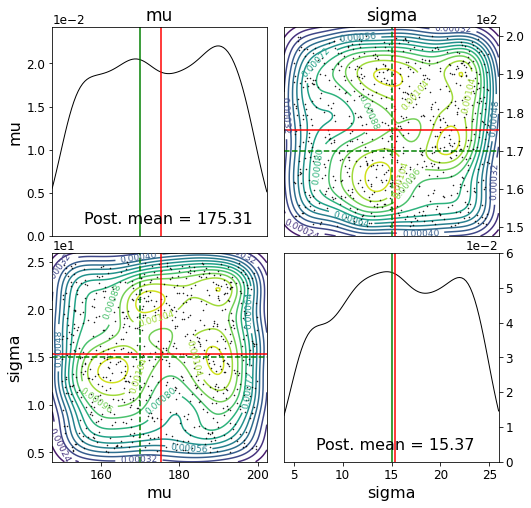

In [360]:
fig1 = plt.figure()
journal.plot_posterior_distr(true_parameter_values = [170, 15])
plt.savefig('example_result')

Now we plot the convergence.

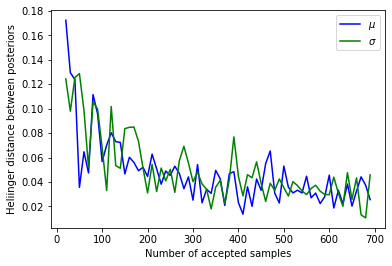

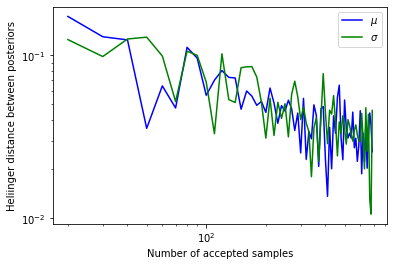

In [370]:
def plot_posterior_conv(param):
    hell_mu = []
    hell_sigma = []
    
    for i in range(len(param) - 1):

        hell_mu.append(hell_Gaussian(param[i]['mu'], param[i+1]['mu'], 0.3, n=1000, plot = False))
        hell_sigma.append(hell_Gaussian(param[i]['sigma'], param[i+1]['sigma'], 0.3, n=1000, plot = False))
    
    fig1 = plt.figure()
    plt.plot((np.arange(20, 700, 10)), ((np.array(hell_mu))), 'b', label=r'$\mu$')
    plt.plot((np.arange(20, 700, 10)), ((np.array(hell_sigma))), 'g', label=r'$\sigma$')
    
    plt.xlabel('Number of accepted samples')
    plt.ylabel('Heliinger distance between posteriors')
    #plt.title('Histogram of IQ')
    plt.legend()
    plt.savefig('posteriorConv')
    
    fig2 = plt.figure()
    plt.loglog((np.arange(20, 700, 10)), ((np.array(hell_mu))), 'b', label=r'$\mu$')
    plt.loglog((np.arange(20, 700, 10)), ((np.array(hell_sigma))), 'g', label=r'$\sigma$')
    
    plt.xlabel('Number of accepted samples')
    plt.ylabel('Heliinger distance between posteriors')
    #plt.title('Histogram of IQ')
    plt.legend()
    plt.savefig('posteriorConvlog')

plot_posterior_conv(param)
                
                
                

In [ ]:
def plot_posterior_conv(param):
    hell_mu = []
    hell_sigma = []
    
    for i in range(len(param) - 1):

        hell_mu.append(hell_Gaussian(param[i]['mu'], param[i+1]['mu'], 0.3, n=1000, plot = False))
        hell_sigma.append(hell_Gaussian(param[i]['sigma'], param[i+1]['sigma'], 0.3, n=1000, plot = False))
    
    fig1 = plt.figure()
    plt.plot((np.arange(20, 700, 10)), ((np.array(hell_mu))), 'b', label=r'$\mu$')
    plt.plot((np.arange(20, 700, 10)), ((np.array(hell_sigma))), 'g', label=r'$\sigma$')
    
    plt.xlabel('Number of accepted samples')
    plt.ylabel('Heliinger distance between posteriors')
    #plt.title('Histogram of IQ')
    plt.legend()
    plt.savefig('posteriorConv')
    
    fig2 = plt.figure()
    plt.loglog((np.arange(20, 700, 10)), ((np.array(hell_mu))), 'b', label=r'$\mu$')
    plt.loglog((np.arange(20, 700, 10)), ((np.array(hell_sigma))), 'g', label=r'$\sigma$')
    
    plt.xlabel('Number of accepted samples')
    plt.ylabel('Heliinger distance between posteriors')
    #plt.title('Histogram of IQ')
    plt.legend()
    plt.savefig('posteriorConvlog')

plot_posterior_conv(param)
                

## Stability

Suppose we have observed data $x_1$ and $x_2$ with corresponding summary statistics $s_0$ and $s_1$, we want to verify the Lipschitz stability:
$$
||\theta_{x_1} - \theta_{x_2}||\leq c ||s_1 - s_2||
$$
for different distances. To be more precise, we want to verify for hellinger distance and Monte Carlo distance. 

First we generate an observed data $x_1$, then make various noises for $x_1$ to generate various new oberved data. We record the journal for all observed data, which contains all accepted parameters given the observed data.

In [383]:
# define priors
mu = Uniform([[150], [2000]], name="mu")
sigma = Uniform([[5], [250]], name="sigma")
# define the model
height = Gaussian([mu, sigma], name='height')
# Initialise ABC
statistics_calculator = Identity(degree=1, cross=False)
distance_calculator = Euclidean(statistics_calculator)
backend = Backend()
sampler = RejectionABC([height], [distance_calculator], backend, seed=1)
n_sample, n_samples_per_param = 200, 1
epsilon = 200

# Generate x_1
height_obs0 = height.forward_simulate([170, 10], k=50)
journal0 = sampler.sample([height_obs0], n_sample, n_samples_per_param, epsilon)

# Record oberved data and journal of ABC
observed_data = [height_obs0]
journals = [journal0]

for i in range(200):
    # Noised observed data
    noise = np.array(np.random.normal((i**3)*1e-4, 1*1e-4, 50))
    height_obs = [height_obs0[i] + noise[i] for i in range(50)] 
    observed_data.append(height_obs)
    
    # Implement ABC
    journal = sampler.sample([height_obs], n_sample, n_samples_per_param, epsilon)
    journals.append(journal)
    


Now we plot the Monte Carlo Stability.

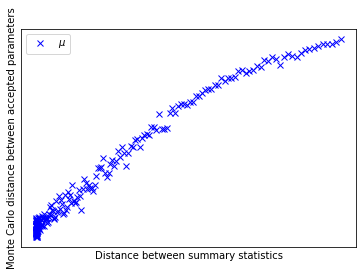

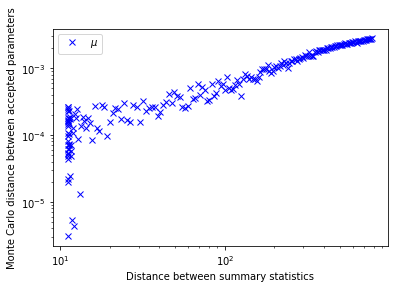

In [412]:
def plot_MonteCarlo_Stability(observed_data, journals):
    distance_summary = []
    monte_mu = []
    monte_sigma = []
    
    # Recover x_1
    height_obs0 = observed_data[0]
    params0 = journals[0].get_parameters()
    
    # Compute distance between sumamry statistics
    for data in observed_data[1:]:
        distance_summary.append(distance_calculator.distance(data, height_obs0))

    for journal in journals[1:]:
        # Observe posterior
        #journal.plot_posterior_distr(true_parameter_values=[170,15])
        
        # Compute Monte Carlo distance
        params = journal.get_parameters()
        monte_mu.append(monte_carlo(params0['mu'], params['mu'], h, 170))
        monte_sigma.append(monte_carlo(params0['sigma'], params['sigma'], h, 10))
    
    fig1 = plt.figure()
    plt.plot((distance_summary), (np.array(monte_mu)), 'bx', label=r'$\mu$')
    #plt.plot((distance_summary), (np.array(monte_sigma)), 'gx', label=r'$\sigma$')
    
    plt.xlabel('Distance between summary statistics')
    plt.ylabel('Monte Carlo distance between accepted parameters')
    #plt.title('Histogram of IQ')
    plt.legend()
    plt.savefig('MonteCarloStability200')
    
    fig2 = plt.figure()
    plt.loglog((distance_summary), (np.array(monte_mu)), 'bx', label=r'$\mu$')
    #plt.loglog(diabetes_X_test, diabetes_y_pred, color="blue", linewidth=3)
    #plt.plot((distance_summary), (np.array(monte_sigma)), 'gx', label=r'$\sigma$')
    
    plt.xlabel('Distance between summary statistics')
    plt.ylabel('Monte Carlo distance between accepted parameters')
    #plt.title('Histogram of IQ')
    plt.legend()
    plt.savefig('MonteCarloStabilitylog200')
    
    #plt.xlim([0, 100])


plot_MonteCarlo_Stability(observed_data, journals)

Coefficients: 
 [[1.08207251]]
Mean squared error: 0.54
Coefficient of determination: 0.83


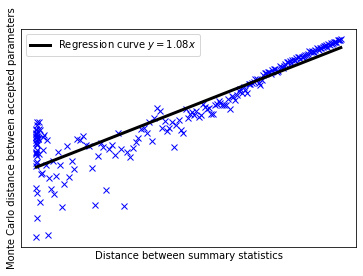

In [440]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes_X = np.array(np.log(distance_summary)).reshape(-1, 1)
diabetes_y = np.array(np.log(monte_mu)).reshape(-1, 1)

# Split the data into training/testing sets
diabetes_X_train = diabetes_X
diabetes_X_test = diabetes_X

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y
diabetes_y_test = diabetes_y

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
fig = plt.figure()
plt.plot(np.log(distance_summary), np.log(monte_mu), "bx")
plt.plot(np.log(distance_summary), diabetes_y_pred, color="black", linewidth=3, label="Regression curve $y = 1.08x$")

plt.xticks(())
plt.yticks(())

plt.xlabel('Distance between summary statistics')
plt.ylabel('Monte Carlo distance between accepted parameters')
#plt.title('Histogram of IQ')
plt.legend()
plt.savefig('MonteCarloStabilityConst')


plt.show()



We can also plot the Hellinger convergence.

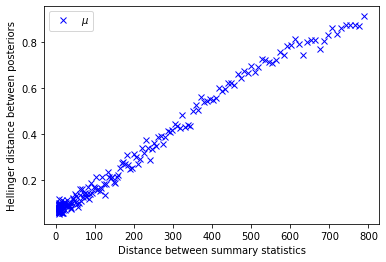

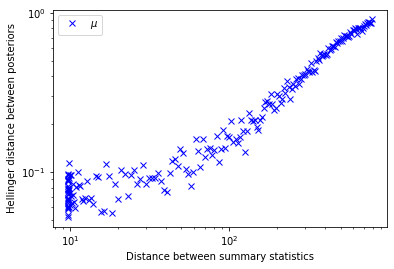

In [372]:
def plot_Hellinger_Stability(observed_data, journals):
    distance_summary = []
    hell_mu = []
    hell_sigma = []
    
    # Recover x_1
    height_obs0 = observed_data[0]
    params0 = journals[0].get_parameters()
    
    # Compute distance between sumamry statistics
    for data in observed_data[1:]:
        distance_summary.append(distance_calculator.distance(data, height_obs0))

    for journal in journals[1:]:
        # Observe posterior
        #journal.plot_posterior_distr(true_parameter_values=[170,15])
        
        # Compute Monte Carlo distance
        params = journal.get_parameters()
        hell_mu.append(hell_Gaussian(params0['mu'], params['mu'], 0.3, n=1000, plot = False))
        hell_sigma.append(hell_Gaussian(params0['sigma'], params['sigma'], 0.3, n=1000, plot = False))
    
    fig1 = plt.figure()
    plt.plot((distance_summary), (np.array(hell_mu)), 'bx', label=r'$\mu$')
    #plt.plot((distance_summary), (np.array(hell_sigma)), 'gx', label=r'$\sigma$')
    
    plt.xlabel('Distance between summary statistics')
    plt.ylabel('Hellinger distance between posteriors')
    #plt.title('Histogram of IQ')
    plt.legend()
    plt.savefig('HellStability')
    
    fig2 = plt.figure()
    plt.loglog((distance_summary), (np.array(hell_mu)), 'bx', label=r'$\mu$')
    #plt.plot((distance_summary), (np.array(hell_sigma)), 'gx', label=r'$\sigma$')
    
    plt.xlabel('Distance between summary statistics')
    plt.ylabel('Hellinger distance between posteriors')
    #plt.title('Histogram of IQ')
    plt.legend()
    plt.savefig('HellStabilitylog')

plot_Hellinger_Stability(observed_data, journals)

Coefficients: 
 [[1.24566082]]
Mean squared error: 0.18
Coefficient of determination: 0.95


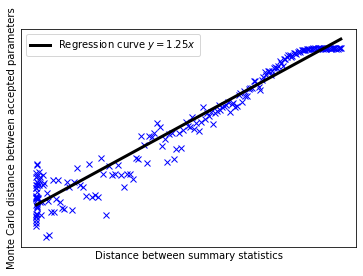

In [441]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes_X = np.array(np.log(distance_summary)).reshape(-1, 1)
diabetes_y = np.array(np.log(hell_mu)).reshape(-1, 1)

# Split the data into training/testing sets
diabetes_X_train = diabetes_X
diabetes_X_test = diabetes_X

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y
diabetes_y_test = diabetes_y

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
fig = plt.figure()
plt.plot(np.log(distance_summary), np.log(hell_mu), "bx")
plt.plot(np.log(distance_summary), diabetes_y_pred, color="black", linewidth=3, label="Regression curve $y = 1.25x$")

plt.xticks(())
plt.yticks(())

plt.xlabel('Distance between summary statistics')
plt.ylabel('Monte Carlo distance between accepted parameters')
#plt.title('Histogram of IQ')
plt.legend()
plt.savefig('HellStabilityConst')


plt.show()